In [480]:
### Multi-class classification

In [481]:
import torch
from torch import nn   # pytroch building blocks for neural network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make data
import sklearn
from sklearn.datasets import make_blobs

In [482]:
# Prepare blob data

X_blob, y_blob = make_blobs(n_samples=3000, # number of dots
                            n_features=2,  # number of dimensions for each dot (int this case 2 for x and y)
                            centers=5, # number of different colors (categories)
                            cluster_std=1.3,  # How dense is each category cluster (higher means less dense)
                            random_state=104)

In [483]:
# Display data as a dataframe

blobs = pd.DataFrame({"X1": X_blob[:,0], 
                        "X2": X_blob[:,1],
                        "Label":y_blob})
blobs.head()

,X1,X2,Label
0,6.476628,-2.897658,1
1,-7.589501,-6.202368,0
2,-2.640029,3.928249,4
3,-0.152832,0.810074,4
4,-2.458563,9.729014,3


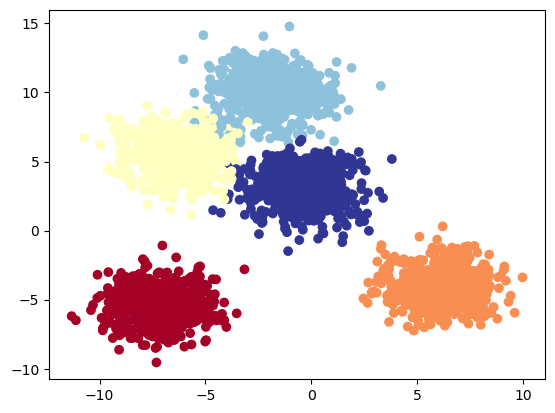

In [484]:
plt.scatter(x=X_blob[:, 0], y=X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu, alpha=1)

In [485]:
# Convert data to tensor

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # Using LongTensor because we want to classify into 6 categories

In [486]:
# Split data to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X_blob, y_blob, test_size=0.25, random_state=314)

In [487]:
## Build a model for classification of circles

# This model is for non-linear data
class CircleClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Create nn.linear layer that can handle the data
        self.layer_1 = nn.Linear(in_features=2, out_features=40) # take in two values(point coordinates) and upscale it to 40
        self.layer_2 = nn.Linear(in_features=40, out_features=40) # process 40 upscaled values
        self.layer_3 = nn.Linear(in_features=40, out_features=40) # process 40 upscaled values
        self.layer_4 = nn.Linear(in_features=40, out_features=40) # process 40 upscaled values
        self.layer_5 = nn.Linear(in_features=40, out_features=40) # process 40 upscaled values
        self.out_layer = nn.Linear(in_features=40, out_features=9) # take the 40 processed values and output 6 answer (4 different colors of blobs)
        
        self.relu = nn.ReLU()# ReLu change all negative values to zero, and is a non-linear activation function

    def forward(self, X):
        X = X.float()
        return self.out_layer(self.relu(self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))))))))
    
# Random seed
torch.manual_seed(100)

model = CircleClassificationModel()

# Simpler way to set up basic model
'''
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=20),
    nn.Linear(in_features=20, out_features=20),
    nn.Linear(in_features=20, out_features=20),
    nn.Linear(in_features=20, out_features=1)
)
'''

model

CircleClassificationModel(
  (layer_1): Linear(in_features=2, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=40, bias=True)
  (layer_3): Linear(in_features=40, out_features=40, bias=True)
  (layer_4): Linear(in_features=40, out_features=40, bias=True)
  (layer_5): Linear(in_features=40, out_features=40, bias=True)
  (out_layer): Linear(in_features=40, out_features=9, bias=True)
  (relu): ReLU()
)

In [488]:
# Accuracy function
def calculate_accuracy(y_truth, y_pred):
    correct = torch.eq(y_truth, y_pred).sum().item()
    return correct/len(y_pred) * 100

In [489]:
# Create loss function and optimizer

# Loss function
loss_function = nn.CrossEntropyLoss() # Loss function calculate how well the model's predictions match the actual labels.

# Create optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)  # Learning rate is a hyperparameter that determines how much the model learns in each step.
# optimizer adjusts the model's weights and biases to minimize the loss.

In [490]:
# Convert model output(logits) to prediction probabilities 
# by applying softmax function and select the maximum probability

# This is an example of how to convert logits to probabilities and to labels using softmax and argmax

with torch.inference_mode():
    logits = model(X_train)
preds_probabilities = torch.softmax(logits, dim=1)
labels = torch.argmax(preds_probabilities, dim=1)
labels[:5]


tensor([5, 5, 0, 5, 5])

In [491]:
## Training loop
epochs = 4000

# Loop through data
for epoch in range(epochs):
    model.train()

    # Forward pass
    train_logits = model(X_train)
    train_preds_probabilities = torch.softmax(train_logits, dim=1)
    train_label = torch.argmax(train_preds_probabilities, dim=1)

    # Calculate loss
    train_loss = loss_function(train_logits, y_train)

    # Train accuracy
    train_accuracy = calculate_accuracy(y_truth=y_train, y_pred=train_label)

    # Zero the gradients before performing backpropagation
    optimizer.zero_grad()

    # Backward pass and optimization
    train_loss.backward() # Backpropagation happens here
    optimizer.step()

    ## Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_preds_probabilities = torch.softmax(test_logits, dim=1)
        test_label = torch.argmax(test_preds_probabilities, dim=1)
        test_accuracy = calculate_accuracy(y_truth=y_test, y_pred=test_label)

    if(epoch % 200 == 0):
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train accuracy: {train_accuracy:.2f}% | Test accuracy: {test_accuracy:.2f}%")



Epoch: 0 | Train loss: 2.2496 | Train accuracy: 2.53% | Test accuracy: 3.07%
Epoch: 200 | Train loss: 1.5940 | Train accuracy: 20.49% | Test accuracy: 18.53%
Epoch: 400 | Train loss: 0.5751 | Train accuracy: 80.13% | Test accuracy: 77.20%
Epoch: 600 | Train loss: 0.2776 | Train accuracy: 86.93% | Test accuracy: 83.47%
Epoch: 800 | Train loss: 0.2173 | Train accuracy: 92.71% | Test accuracy: 91.87%
Epoch: 1000 | Train loss: 0.1708 | Train accuracy: 95.73% | Test accuracy: 96.27%
Epoch: 1200 | Train loss: 0.1333 | Train accuracy: 96.98% | Test accuracy: 98.00%
Epoch: 1400 | Train loss: 0.1062 | Train accuracy: 97.60% | Test accuracy: 98.67%
Epoch: 1600 | Train loss: 0.0862 | Train accuracy: 98.09% | Test accuracy: 98.80%
Epoch: 1800 | Train loss: 0.0709 | Train accuracy: 98.44% | Test accuracy: 98.80%
Epoch: 2000 | Train loss: 0.0595 | Train accuracy: 98.71% | Test accuracy: 99.07%
Epoch: 2200 | Train loss: 0.0510 | Train accuracy: 98.76% | Test accuracy: 99.20%
Epoch: 2400 | Train loss:

In [492]:
# Make predictions

with torch.inference_mode():
    test_predictions = model(X_test)
    test_probabilities = torch.softmax(test_predictions, dim=1)
    test_predicted_labels = torch.argmax(test_probabilities, dim=1)
    test_predicted_labels[:5]

In [493]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

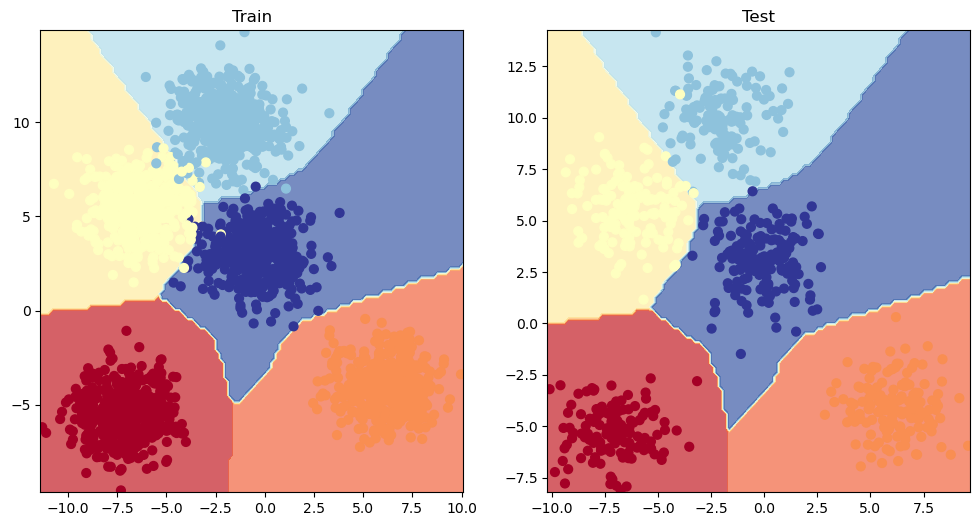

In [494]:
# Model using relu activation function

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

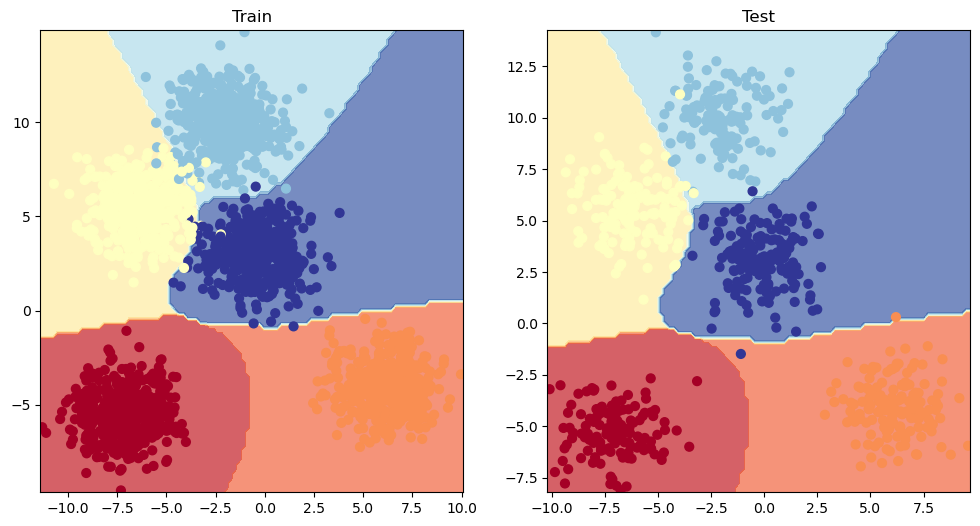

In [497]:
# Model using tanh activation function, the only change in code is changing the activation function in the model (RuLU to Tanh)
# This model can be trained and evaluated in the same way as the previous model.
# But the code to train it is omitted for brevity, but the model is still saved as "model_tanh.pt"

model_loaded = torch.load("model_tanh.pt")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_loaded, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_loaded, X_test, y_test)